In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

from sentence_transformers import SentenceTransformer, util
from transformers import CLIPModel, AutoTokenizer, AutoProcessor
# import evaluate
import pandas as pd

from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
from models import GNet8_Encoder

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

accelerator = Accelerator(split_batches=False, mixed_precision="fp16") # ['no', 'fp8', 'fp16', 'bf16']

print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)
print = accelerator.print # only print if local_rank=0

LOCAL RANK  0
PID of this process = 5011
device: cuda
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1


In [2]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "multisubject_subj5_session1_1978"
    all_recons_path = f"/root/autodl-tmp/NSD/mindeyev2_dataset/{model_name}_all_recons.pt"
    subj = 5
    
    data_path = "/root/autodl-tmp/NSD/mindeyev2_dataset"
    cache_dir = "/root/autodl-tmp/clip"
    
    print("model_name:", model_name)

    jupyter_args = f"--model_name={model_name} --subj={subj} --data_path={data_path} --cache_dir={cache_dir} --all_recons_path={all_recons_path}"
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: multisubject_subj5_session1_1978
--model_name=multisubject_subj5_session1_1978 --subj=5 --data_path=/root/autodl-tmp/NSD/mindeyev2_dataset --cache_dir=/root/autodl-tmp/clip --all_recons_path=/root/autodl-tmp/NSD/mindeyev2_dataset/multisubject_subj5_session1_1978_all_recons.pt


In [3]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--all_recons_path", type=str,
    help="Path to where all_recons.pt is stored",
)
parser.add_argument(
    "--data_path", type=str, default=os.getcwd(),
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--cache_dir", type=str, default=os.getcwd(),
    help="Path to where misc. files downloaded from huggingface are stored. Defaults to current src directory.",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Evaluate on which subject?",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

# Evals

In [4]:
# ground truths
all_images = torch.load(f"/root/autodl-tmp/fMRI/train_logs/all_images.pt")
# all_captions = torch.load(f"evals/all_captions.pt")

In [5]:
print("all_recons_path:", all_recons_path)
all_recons = torch.load(all_recons_path)

# Residual submodule
all_clipvoxels = torch.load(f"/root/autodl-tmp/NSD/mindeyev2_dataset/{model_name}_all_clipvoxels.pt")
# Low-level submodule
# all_blurryrecons = torch.load(f"evals/{model_name}/{model_name}_all_blurryrecons.pt")
# GIT predicted captions
# all_predcaptions = torch.load(f"evals/{model_name}/{model_name}_all_predcaptions.pt")

# model name
model_name_plus_suffix = f"{model_name}_all_recons"
print(model_name_plus_suffix)
print(all_images.shape)

all_recons_path: /root/autodl-tmp/NSD/mindeyev2_dataset/multisubject_subj5_session1_1978_all_recons.pt
multisubject_subj5_session1_1978_all_recons
torch.Size([1000, 3, 224, 224])


In [6]:
# # create full grid of recon comparisons
from PIL import Image

imsize = 150
if all_images.shape[-1] != imsize:
    all_images = transforms.Resize((imsize,imsize))(all_images).float()
if all_recons.shape[-1] != imsize:
    all_recons = transforms.Resize((imsize,imsize))(all_recons).float()

num_images = all_recons.shape[0]
num_rows = (2 * num_images + 9) // 10

# # Interleave tensors
merged = torch.stack([val for pair in zip(all_images, all_recons) for val in pair], dim=0)

# # Calculate grid size
grid = torch.zeros((num_rows * 10, 3, all_recons.shape[-1], all_recons.shape[-1]))

# # Populate the grid
grid[:2*num_images] = merged
grid_images = [transforms.functional.to_pil_image(grid[i]) for i in range(num_rows * 10)]

# # Create the grid image
grid_image = Image.new('RGB', (all_recons.shape[-1]*10, all_recons.shape[-1] * num_rows))  # 10 images wide

# # Paste images into the grid
for i, img in enumerate(grid_images):
    grid_image.paste(img, (all_recons.shape[-1] * (i % 10), all_recons.shape[-1] * (i // 10)))

grid_image.save(f"{model_name_plus_suffix[:-3]}_1000recons.png")

/root/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
imsize = 256
if all_images.shape[-1] != imsize:
    all_images = transforms.Resize((imsize,imsize))(all_images).float()
if all_recons.shape[-1] != imsize:
    all_recons = transforms.Resize((imsize,imsize))(all_recons).float()
# if all_blurryrecons.shape[-1] != imsize:
    # all_blurryrecons = transforms.Resize((imsize,imsize))(all_blurryrecons).float()
    
# if "enhanced" in model_name_plus_suffix:
#     print("weighted averaging to improve low-level evals")
#     all_recons = all_recons*.75 + all_blurryrecons*.25

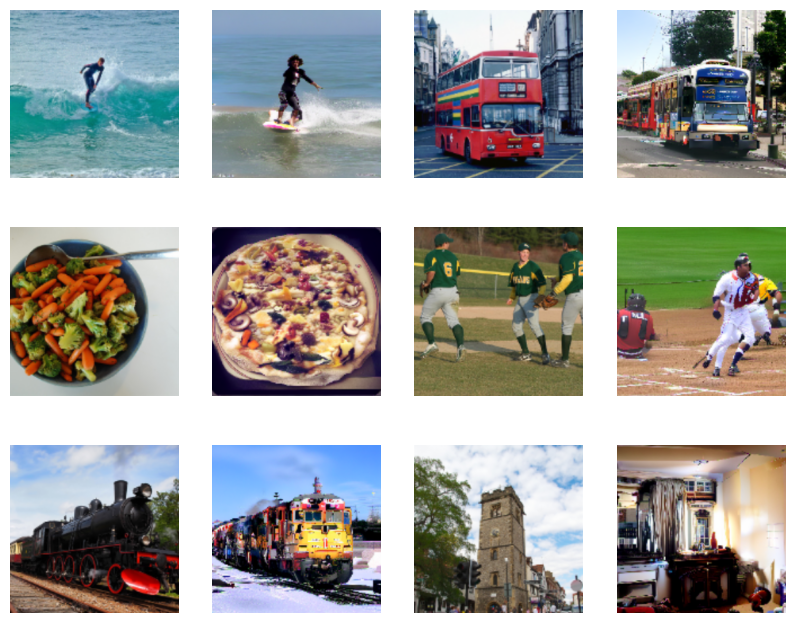

In [8]:
# 2 / 117 / 231 / 164 / 619 / 791
import textwrap
def wrap_title(title, wrap_width):
    return "\n".join(textwrap.wrap(title, wrap_width))

fig, axes = plt.subplots(3, 4, figsize=(10, 8))
jj=-1; kk=0;
for j in np.array([2,165,119,619,231,791]):
    jj+=1
    # print(kk,jj)
    axes[kk][jj].imshow(utils.torch_to_Image(all_images[j]))
    axes[kk][jj].axis('off')
    # axes[kk][jj].set_title(wrap_title(str(all_captions[[j]]),wrap_width=30), fontsize=8)
    jj+=1
    axes[kk][jj].imshow(utils.torch_to_Image(all_recons[j]))
    axes[kk][jj].axis('off')
    # axes[kk][jj].set_title(wrap_title(str(all_predcaptions[[j]]),wrap_width=30), fontsize=8)
    if jj==3: 
        kk+=1; jj=-1

# Retrieval eval

In [12]:
# Load embedding model
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="/root/autodl-tmp/clip/models--laion--CLIP-ViT-bigG-14-laion2B-39B-b160k/resolve/main/open_clip_pytorch_model.bin",
    output_tokens=True,
    only_tokens=True
)
clip_img_embedder.to(device)

clip_seq_dim = 256
clip_emb_dim = 1664

In [13]:
from scipy import stats
percent_correct_fwds, percent_correct_bwds = [], []
percent_correct_fwd, percent_correct_bwd = None, None

with torch.cuda.amp.autocast(dtype=torch.float16):
    for test_i, loop in enumerate(tqdm(range(30))):
        random_samps = np.random.choice(np.arange(len(all_images)), size=300, replace=False)
        emb = clip_img_embedder(all_images[random_samps].to(device)).float() # CLIP-Image

        emb_ = all_clipvoxels[random_samps].to(device).float() # CLIP-Brain

        # flatten if necessary
        emb = emb.reshape(len(emb),-1)
        emb_ = emb_.reshape(len(emb_),-1)

        # l2norm 
        emb = nn.functional.normalize(emb,dim=-1)
        emb_ = nn.functional.normalize(emb_,dim=-1)

        labels = torch.arange(len(emb)).to(device)
        bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
        fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip

        assert len(bwd_sim) == 300

        percent_correct_fwds = np.append(percent_correct_fwds, utils.topk(fwd_sim, labels,k=1).item())
        percent_correct_bwds = np.append(percent_correct_bwds, utils.topk(bwd_sim, labels,k=1).item())

        if test_i==0:
            print("Loop 0:",percent_correct_fwds, percent_correct_bwds)
            
percent_correct_fwd = np.mean(percent_correct_fwds)
fwd_sd = np.std(percent_correct_fwds) / np.sqrt(len(percent_correct_fwds))
fwd_ci = stats.norm.interval(0.95, loc=percent_correct_fwd, scale=fwd_sd)

percent_correct_bwd = np.mean(percent_correct_bwds)
bwd_sd = np.std(percent_correct_bwds) / np.sqrt(len(percent_correct_bwds))
bwd_ci = stats.norm.interval(0.95, loc=percent_correct_bwd, scale=bwd_sd)

print(f"fwd percent_correct: {percent_correct_fwd:.4f} 95% CI: [{fwd_ci[0]:.4f},{fwd_ci[1]:.4f}]")
print(f"bwd percent_correct: {percent_correct_bwd:.4f} 95% CI: [{bwd_ci[0]:.4f},{bwd_ci[1]:.4f}]")

fwd_sim = np.array(fwd_sim.cpu())
bwd_sim = np.array(bwd_sim.cpu())

  3%|▎         | 1/30 [00:04<02:18,  4.76s/it]

Loop 0: [0.92000002] [0.87]


100%|██████████| 30/30 [01:56<00:00,  3.88s/it]

fwd percent_correct: 0.9391 95% CI: [0.9355,0.9427]
bwd percent_correct: 0.8591 95% CI: [0.8525,0.8658]


Given Brain embedding, find correct Image embedding


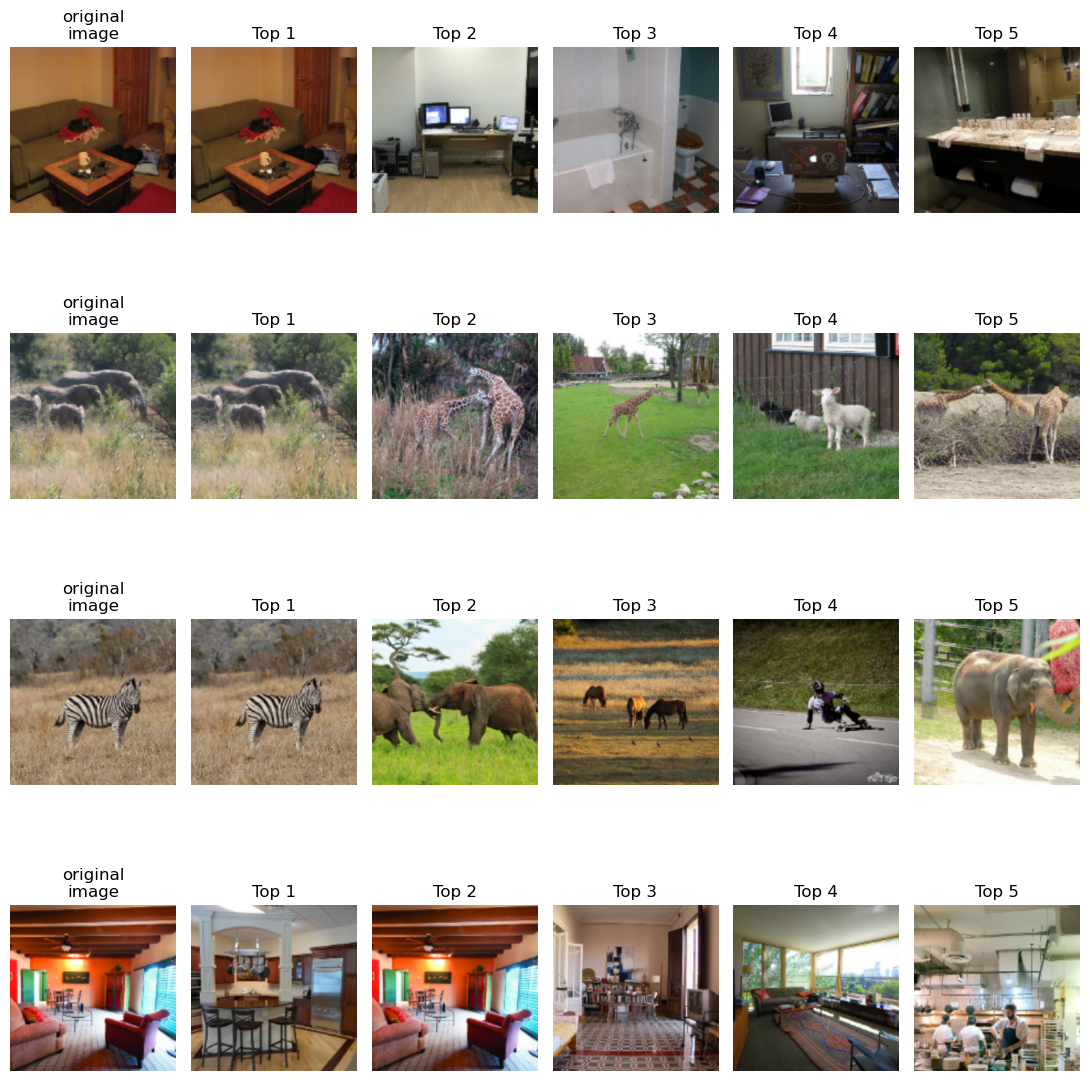

In [24]:
print("Given Brain embedding, find correct Image embedding")
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(all_images[random_samps][trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(fwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(all_images[random_samps][which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

## 2-way identification

In [9]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

@torch.no_grad()
def two_way_identification(all_recons, all_images, model, preprocess, feature_layer=None, return_avg=True):
    preds = model(torch.stack([preprocess(recon) for recon in all_recons], dim=0).to(device))
    reals = model(torch.stack([preprocess(indiv) for indiv in all_images], dim=0).to(device))
    if feature_layer is None:
        preds = preds.float().flatten(1).cpu().numpy()
        reals = reals.float().flatten(1).cpu().numpy()
    else:
        preds = preds[feature_layer].float().flatten(1).cpu().numpy()
        reals = reals[feature_layer].float().flatten(1).cpu().numpy()

    r = np.corrcoef(reals, preds)
    r = r[:len(all_images), len(all_images):]
    congruents = np.diag(r)

    success = r < congruents
    success_cnt = np.sum(success, 0)

    if return_avg:
        perf = np.mean(success_cnt) / (len(all_images)-1)
        return perf
    else:
        return success_cnt, len(all_images)-1

## PixCorr

In [10]:
preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR),
])

# Flatten images while keeping the batch dimension
all_images_flattened = preprocess(all_images).reshape(len(all_images), -1).cpu()
all_recons_flattened = preprocess(all_recons).view(len(all_recons), -1).cpu()

print(all_images_flattened.shape)
print(all_recons_flattened.shape)

corrsum = 0
for i in tqdm(range(len(all_images))):
    corrsum += np.corrcoef(all_images_flattened[i], all_recons_flattened[i])[0][1]
corrmean = corrsum / len(all_images)

pixcorr = corrmean
print(pixcorr)

torch.Size([1000, 541875])
torch.Size([1000, 541875])


100%|██████████| 1000/1000 [00:07<00:00, 140.74it/s]

0.1603550743044064


## SSIM

In [11]:
# see https://github.com/zijin-gu/meshconv-decoding/issues/3
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim

preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR), 
])

# convert image to grayscale with rgb2grey
img_gray = rgb2gray(preprocess(all_images).permute((0,2,3,1)).cpu())
recon_gray = rgb2gray(preprocess(all_recons).permute((0,2,3,1)).cpu())
print("converted, now calculating ssim...")

ssim_score=[]
for im,rec in tqdm(zip(img_gray,recon_gray),total=len(all_images)):
    ssim_score.append(ssim(rec, im, multichannel=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=1.0))

ssim = np.mean(ssim_score)
print(ssim)

/root/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


converted, now calculating ssim...


100%|██████████| 1000/1000 [00:08<00:00, 123.66it/s]

0.37636617921969195


## AlexNet

In [21]:
from torchvision.models import alexnet, AlexNet_Weights
alex_weights = AlexNet_Weights.IMAGENET1K_V1

alex_model = create_feature_extractor(alexnet(weights=alex_weights), return_nodes=['features.4','features.11']).to(device)
alex_model.eval().requires_grad_(False)

# see alex_weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

layer = 'early, AlexNet(2)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_recons.to(device).float(), all_images, 
                                                          alex_model, preprocess, 'features.4')
alexnet2 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet2:.4f}")

layer = 'mid, AlexNet(5)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_recons.to(device).float(), all_images, 
                                                          alex_model, preprocess, 'features.11')
alexnet5 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet5:.4f}")


---early, AlexNet(2)---
2-way Percent Correct: 0.8850

---mid, AlexNet(5)---
2-way Percent Correct: 0.9299


## InceptionV3

In [12]:
from torchvision.models import inception_v3, Inception_V3_Weights
weights = Inception_V3_Weights.DEFAULT
inception_model = create_feature_extractor(inception_v3(weights=weights), 
                                           return_nodes=['avgpool']).to(device)
inception_model.eval().requires_grad_(False)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(342, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

all_per_correct = two_way_identification(all_recons, all_images,
                                        inception_model, preprocess, 'avgpool')
        
inception = np.mean(all_per_correct)
print(f"2-way Percent Correct: {inception:.4f}")

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:19<00:00, 5.72MB/s] 
/root/miniconda3/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/root/miniconda3/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/root/miniconda3/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/root/miniconda3/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/root/miniconda3/lib/python3.10/site-packages/torchvision/models/feature_extraction.py:174: Use

2-way Percent Correct: 0.8450


## CLIP

In [ ]:
import clip
clip_model, preprocess = clip.load("ViT-L/14", device=device)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])

all_per_correct = two_way_identification(all_recons, all_images,
                                        clip_model.encode_image, preprocess, None) # final layer
clip_ = np.mean(all_per_correct)
print(f"2-way Percent Correct: {clip_:.4f}")

 24%|█████████                            | 228M/933M [30:41<2:02:00, 96.3kiB/s]

## Efficient Net

In [199]:
import scipy as sp
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
weights = EfficientNet_B1_Weights.DEFAULT
eff_model = create_feature_extractor(efficientnet_b1(weights=weights), 
                                    return_nodes=['avgpool'])
eff_model.eval().requires_grad_(False)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(255, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

gt = eff_model(preprocess(all_images))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = eff_model(preprocess(all_recons))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

effnet = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
print("Distance:",effnet)

Distance: 0.615303855439648


## SwAV

In [15]:
import scipy as sp
swav_model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
swav_model = create_feature_extractor(swav_model, 
                                    return_nodes=['avgpool'])
swav_model.eval().requires_grad_(False)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

gt = swav_model(preprocess(all_images))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = swav_model(preprocess(all_recons))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

swav = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
print("Distance:",swav)

Using cache found in /root/.cache/torch/hub/facebookresearch_swav_main


Distance: 0.44590024180005733


# Brain Correlation
### Load brain data, brain masks, image lists

In [ ]:
# Load brain data as ground truth
def my_split_by_node(urls): return urls

voxels = {}
# Load hdf5 data for betas
f = h5py.File(f'{data_path}/betas_all_subj0{subj}_fp32_renorm.hdf5', 'r')
betas = f['betas'][:]
betas = torch.Tensor(betas).to("cpu")
f.close()
num_voxels = betas[0].shape[-1]
voxels[f'subj0{subj}'] = betas
print(f"num_voxels for subj0{subj}: {num_voxels}")

if subj==3:
    num_test=2371
elif subj==4:
    num_test=2188
elif subj==6:
    num_test=2371
elif subj==8:
    num_test=2188
else:
    num_test=3000
test_url = f"{data_path}/wds/subj0{subj}/new_test/" + "0.tar"
    
print(test_url)
test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

In [ ]:
# Prep test voxels and indices of test images
test_images_idx = []
for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
    test_voxels = voxels[f'subj0{subj}'][behav[:,0,5].cpu().long()]
    test_images_idx = np.append(test_images_idx, behav[:,0,0].cpu().numpy())
test_images_idx = test_images_idx.astype(int)

assert (test_i+1) * num_test == len(test_voxels) == len(test_images_idx)
print(test_i, len(test_voxels), len(test_images_idx), len(np.unique(test_images_idx)))

In [ ]:
# Load brain region masks
brain_region_masks = {}
with h5py.File("brain_region_masks.hdf5", "r") as file:
    # Iterate over each subject
    for subject in file.keys():
        subject_group = file[subject]
        # Load the masks data for each subject
        subject_masks = {"nsd_general" : subject_group["nsd_general"][:],
                         "V1" : subject_group["V1"][:], 
                         "V2" : subject_group["V2"][:], 
                         "V3" : subject_group["V3"][:], 
                         "V4" : subject_group["V4"][:],
                         "higher_vis" : subject_group["higher_vis"][:]}
        brain_region_masks[subject] = subject_masks
subject_masks = brain_region_masks[f"subj0{subj}"]

# Average voxels of test set across trial repetitions for brain correlation scores
test_voxels_averaged = torch.zeros((len(np.unique(test_images_idx)),num_voxels))
# i = 0
uniq_imgs = np.unique(test_images_idx)
for i, uniq_img in enumerate(uniq_imgs):
    locs = np.where(test_images_idx==uniq_img)[0]
    if len(locs)==1:
        locs = locs.repeat(3)
    elif len(locs)==2:
        locs = locs.repeat(2)[:3]
    assert len(locs)==3
    test_voxels_averaged[i] = torch.mean(test_voxels[None,locs], dim=1)

# Prepare image list for input to GNet
recon_list = []
for i in range(all_recons.shape[0]):
    img = all_recons[i].detach()
    img = transforms.ToPILImage()(img)
    recon_list.append(img)

### Calculate Brain Correlation scores for each brain area

In [ ]:
from torchmetrics import PearsonCorrCoef
GNet = GNet8_Encoder(device=device,subject=subj,model_path=f"{cache_dir}/gnet_multisubject.pt")
PeC = PearsonCorrCoef(num_outputs=len(recon_list))
beta_primes = GNet.predict(recon_list)

region_brain_correlations = {}
for region, mask in subject_masks.items():
    score = PeC(test_voxels_averaged[:,mask].moveaxis(0,1), beta_primes[:,mask].moveaxis(0,1))
    region_brain_correlations[region] = float(torch.mean(score))
print(region_brain_correlations)

In [ ]:
# Create a dictionary to store variable names and their corresponding values
import pandas as pd
data = {
    "Metric": ["PixCorr", "SSIM", "AlexNet(2)", "AlexNet(5)", "InceptionV3", "CLIP", "EffNet-B", "SwAV", "FwdRetrieval", "BwdRetrieval",
               "Brain Corr. nsd_general", "Brain Corr. V1", "Brain Corr. V2", "Brain Corr. V3", "Brain Corr. V4",  "Brain Corr. higher_vis"],
    "Value": [pixcorr, ssim, alexnet2, alexnet5, inception, clip_, effnet, swav, percent_correct_fwd, percent_correct_bwd, 
              region_brain_correlations["nsd_general"], region_brain_correlations["V1"], region_brain_correlations["V2"], region_brain_correlations["V3"], region_brain_correlations["V4"], region_brain_correlations["higher_vis"]]}

df = pd.DataFrame(data)
print(model_name_plus_suffix)
print(df.to_string(index=False))
print(df["Value"].to_string(index=False))

# save table to txt file
os.makedirs('tables/',exist_ok=True)
df["Value"].to_csv(f'tables/{model_name_plus_suffix}.csv', sep='\t', index=False)

# Captions evaluation


In [ ]:
all_git_generated_captions = torch.load(f"evals/all_git_generated_captions.pt")

## Meteor

In [35]:
meteor = evaluate.load('meteor')
meteor_img_ref=meteor.compute(predictions=all_git_generated_captions,references=all_captions)
meteor_brain_ref=meteor.compute(predictions=all_predcaptions,references=all_captions)
meteor_brain_img=meteor.compute(predictions=all_predcaptions,references=all_git_generated_captions)


relative_brain_image_meteor=meteor_brain_img["meteor"]/meteor_img_ref["meteor"]

print(f"[GROUND] METEOR GIT from images vs captions: {meteor_img_ref['meteor']}")
print(f"[ABSOLUTE] METEOR GIT from brain vs captions: {meteor_brain_ref['meteor']}")
print(f"[ABSOLUTE] METEOR GIT from brain vs images: {meteor_brain_img['meteor']}")
print(f"[RELATIVE] METEOR  {relative_brain_image_meteor}")

[nltk_data] Downloading package wordnet to /home/ckadirt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ckadirt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ckadirt/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[GROUND] METEOR GIT from images vs captions: 0.4196759954156638
[ABSOLUTE] METEOR GIT from brain vs captions: 0.24818364743909646
[ABSOLUTE] METEOR GIT from brain vs images: 0.34368216451800593
[RELATIVE] METEOR  0.8189226171432784


## Rouge

In [36]:
rouge = evaluate.load('rouge')
rouge_img_ref=rouge.compute(predictions=all_git_generated_captions,references=all_captions)
rouge_brain_ref=rouge.compute(predictions=all_predcaptions,references=all_captions)
rouge_brain_img=rouge.compute(predictions=all_predcaptions,references=all_git_generated_captions)


relative_brain_image_rouge1 = rouge_brain_img['rouge1']/rouge_img_ref['rouge1']
relative_brain_image_rougeL = rouge_brain_img['rougeL']/rouge_img_ref['rougeL']

print(f"[GROUND] ROUGE-1 GIT from images vs captions: {rouge_img_ref['rouge1']}")
print(f"[ABSOLUTE] ROUGE-1 GIT from brain vs captions: {rouge_brain_ref['rouge1']}")
print(f"[ABSOLUTE] ROUGE-1 GIT from brain vs images: {rouge_brain_img['rouge1']}")
print(f"[RELATIVE] ROUGE-1  {relative_brain_image_rouge1}")

print(f"[GROUND] ROUGE-L GIT from images vs captions: {rouge_img_ref['rougeL']}")
print(f"[ABSOLUTE] ROUGE-L GIT from brain vs captions: {rouge_brain_ref['rougeL']}")
print(f"[ABSOLUTE] ROUGE-L GIT from brain vs images: {rouge_brain_img['rougeL']}")
print(f"[RELATIVE] ROUGE-L  {relative_brain_image_rougeL}")

[GROUND] ROUGE-1 GIT from images vs captions: 0.5072161966446944
[ABSOLUTE] ROUGE-1 GIT from brain vs captions: 0.3528967669453943
[ABSOLUTE] ROUGE-1 GIT from brain vs images: 0.45523149556897663
[RELATIVE] ROUGE-1  0.897509777054432
[GROUND] ROUGE-L GIT from images vs captions: 0.4635805854336489
[ABSOLUTE] ROUGE-L GIT from brain vs captions: 0.3263622143005811
[ABSOLUTE] ROUGE-L GIT from brain vs images: 0.4274517247592156
[RELATIVE] ROUGE-L  0.922065630421867


## Sentence transformer

In [37]:
sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


with torch.no_grad():
    embedding_brain= sentence_model.encode(all_predcaptions, convert_to_tensor=True)
    embedding_captions = sentence_model.encode(all_captions, convert_to_tensor=True)
    embedding_images = sentence_model.encode(all_git_generated_captions, convert_to_tensor=True)

    ss_sim_brain_img=util.pytorch_cos_sim(embedding_brain, embedding_images).cpu()
    ss_sim_brain_cap=util.pytorch_cos_sim(embedding_brain, embedding_captions).cpu()
    ss_sim_img_cap=util.pytorch_cos_sim(embedding_images, embedding_captions).cpu()

    relative_brain_image_ss=ss_sim_brain_img.diag().mean()/ss_sim_img_cap.diag().mean()

In [38]:
print(f"[GROUND] Sentence Transformer Similarity GIT from images vs captions: {ss_sim_img_cap.diag().mean()}")
print(f"[ABSOLUTE] Sentence Transformer Similarity GIT from brain vs captions: {ss_sim_brain_cap.diag().mean()}")
print(f"[ABSOLUTE] Sentence Transformer Similarity GIT from brain vs images: {ss_sim_brain_img.diag().mean()}")
print(f"[RELATIVE] Sentence Transformer Similarity   {relative_brain_image_ss.mean()}")

[GROUND] Sentence Transformer Similarity GIT from images vs captions: 0.7190074324607849
[ABSOLUTE] Sentence Transformer Similarity GIT from brain vs captions: 0.4794784486293793
[ABSOLUTE] Sentence Transformer Similarity GIT from brain vs images: 0.5233524441719055
[RELATIVE] Sentence Transformer Similarity   0.7278818488121033


## CLIP

#### CLIP-B

In [39]:
model_clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor_clip = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer =  AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

with torch.no_grad():
    input_ids=tokenizer(list(all_predcaptions),return_tensors="pt",padding=True)
    embedding_brain= model_clip.get_text_features(**input_ids)

    input_ids=tokenizer(list(all_captions),return_tensors="pt",padding=True)
    embedding_captions= model_clip.get_text_features(**input_ids)

    input_ids=tokenizer(all_git_generated_captions,return_tensors="pt",padding=True)
    embedding_images= model_clip.get_text_features(**input_ids)

clip_B_sim_brain_img=util.pytorch_cos_sim(embedding_brain, embedding_images).cpu()
clip_B_sim_brain_cap=util.pytorch_cos_sim(embedding_brain, embedding_captions).cpu()
clip_B_sim_img_cap=util.pytorch_cos_sim(embedding_images, embedding_captions).cpu()

relative_brain_image_clip_B=clip_B_sim_brain_img.diag().mean()/clip_B_sim_img_cap.diag().mean()

print(f"[GROUND] CLIP Similarity GIT from images vs captions: {clip_B_sim_img_cap.diag().mean()}")
print(f"[ABSOLUTE] CLIP Similarity GIT from brain vs captions: {clip_B_sim_brain_cap.diag().mean()}")
print(f"[ABSOLUTE] CLIP Similarity GIT from brain vs images: {clip_B_sim_brain_img.diag().mean()}")
print(f"[RELATIVE] CLIP Similarity   {relative_brain_image_clip_B.mean()}")

[GROUND] CLIP Similarity GIT from images vs captions: 0.8392383456230164
[ABSOLUTE] CLIP Similarity GIT from brain vs captions: 0.7374086976051331
[ABSOLUTE] CLIP Similarity GIT from brain vs images: 0.7537809014320374
[RELATIVE] CLIP Similarity   0.8981726169586182


#### CLIP-L

In [40]:
model_clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor_clip = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
tokenizer =  AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")

with torch.no_grad():
    input_ids=tokenizer(list(all_predcaptions),return_tensors="pt",padding=True)
    embedding_brain= model_clip.get_text_features(**input_ids)

    input_ids=tokenizer(list(all_captions),return_tensors="pt",padding=True)
    embedding_captions= model_clip.get_text_features(**input_ids)

    input_ids=tokenizer(all_git_generated_captions,return_tensors="pt",padding=True)
    embedding_images= model_clip.get_text_features(**input_ids)

clip_L_sim_brain_img=util.pytorch_cos_sim(embedding_brain, embedding_images).cpu()
clip_L_sim_brain_cap=util.pytorch_cos_sim(embedding_brain, embedding_captions).cpu()
clip_L_sim_img_cap=util.pytorch_cos_sim(embedding_images, embedding_captions).cpu()

relative_brain_image_clip_L=clip_L_sim_brain_img.diag().mean()/clip_L_sim_img_cap.diag().mean()

print(f"[GROUND] CLIP Similarity GIT from images vs captions: {clip_L_sim_img_cap.diag().mean()}")
print(f"[ABSOLUTE] CLIP Similarity GIT from brain vs captions: {clip_L_sim_brain_cap.diag().mean()}")
print(f"[ABSOLUTE] CLIP Similarity GIT from brain vs images: {clip_L_sim_brain_img.diag().mean()}")
print(f"[RELATIVE] CLIP Similarity   {relative_brain_image_clip_L.mean()}")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


[GROUND] CLIP Similarity GIT from images vs captions: 0.7765910625457764
[ABSOLUTE] CLIP Similarity GIT from brain vs captions: 0.6375530958175659
[ABSOLUTE] CLIP Similarity GIT from brain vs images: 0.6710334420204163
[RELATIVE] CLIP Similarity   0.8640756607055664


In [41]:
caption_metrics={ 
            "Rouge1_img_ref":rouge_img_ref['rouge1'],
            "Rouge1_brain_ref":rouge_brain_ref['rouge1'],
            "Rouge1_brain_img":rouge_brain_img['rouge1'],
            "Rouge1_relative":relative_brain_image_rouge1.mean(),
            "RougeL_img_ref":rouge_img_ref['rougeL'],
            "RougeL_brain_ref":rouge_brain_ref['rougeL'],
            "RougeL_brain_img":rouge_brain_img['rougeL'],
            "RougeL_relative":relative_brain_image_rougeL.mean(),
            "Meteor_img_ref":meteor_img_ref['meteor'],
            "Meteor_brain_ref":meteor_brain_ref['meteor'],
            "Meteor_brain_img":meteor_brain_img['meteor'],
            "Meteor_relative":relative_brain_image_meteor,
            "Sentence_img_ref":ss_sim_img_cap.diag().mean().item(),
            "Sentence_brain_ref":ss_sim_brain_cap.diag().mean().item(),
            "Sentence_brain_img":ss_sim_brain_img.diag().mean().item(),
            "Sentence_relative":relative_brain_image_ss.mean().item(),
            "CLIP-B_img_ref":clip_B_sim_img_cap.diag().mean().item(),
            "CLIP-B_brain_ref":clip_B_sim_brain_cap.diag().mean().item(),
            "CLIP-B_brain_img":clip_B_sim_brain_img.diag().mean().item(),
            "CLIP-B_relative":relative_brain_image_clip_B.mean().item(),
            "CLIP-L_img_ref":clip_L_sim_img_cap.diag().mean().item(),
            "CLIP-L_brain_ref":clip_L_sim_brain_cap.diag().mean().item(),
            "CLIP-L_brain_img":clip_L_sim_brain_img.diag().mean().item(),
            "CLIP-L_relative":relative_brain_image_clip_L.mean().item(),
            }

os.makedirs('tables/',exist_ok=True)
df=pd.DataFrame.from_dict(caption_metrics,orient='index',columns=["Value"])
df.to_csv(f'tables/{model_name_plus_suffix}_caption_metrics.csv', sep='\t', index=False)

# UMAP

In [24]:
import umap
from scipy.spatial import distance

print(all_recons_path)
all_recons = torch.load(all_recons_path)
all_backbones = torch.load(f"evals/{model_name}/{model_name}_all_backbones.pt")
all_prior_out = torch.load(f"evals/{model_name}/{model_name}_all_prior_out.pt")
all_clipvoxels = torch.load(f"evals/{model_name}/{model_name}_all_clipvoxels.pt")

# Image feature
all_clipimgs = clip_img_embedder(all_images.to(device)).float() # CLIP-Image
clipimgs_np = all_clipimgs.flatten(1).detach().cpu().numpy()
prior_out_np = all_prior_out.flatten(1).detach().cpu().numpy()
backbones_np = all_backbones.flatten(1).detach().cpu().numpy()
clipvoxels_np = all_clipvoxels.flatten(1).detach().cpu().numpy()

reducer = umap.UMAP(random_state=seed)

In [ ]:
# # Retrieval
plt.figure(figsize=(5, 5))
data1=clipimgs_np
data2=clipvoxels_np
label="Voxels"
color="orange"

embedding = reducer.fit_transform(np.concatenate((data1, data2), axis=0))
euclidean_dist = np.mean(np.linalg.norm(embedding[:len(data1), :] - embedding[len(data1):, :], axis=1))

# subplot
plt.scatter(embedding[:len(data1), 0], embedding[:len(data1), 1], c='blue', label='Images', alpha=.5)
plt.scatter(embedding[len(data1):, 0], embedding[len(data1):, 1], c=color, label=label, alpha=.5)
plt.title(f'CLIP Image x Retrieval Submodule\nAvg. euclidean distance = {euclidean_dist:.2f}')
plt.savefig(f'{model_name}_umap_retrieval.png')
plt.show()

In [ ]:
# Prior_Out
plt.figure(figsize=(5, 5))
data1=clipimgs_np
data2=prior_out_np
label="Prior_Out"
color="red"

embedding = reducer.fit_transform(np.concatenate((data1, data2), axis=0))
euclidean_dist = np.mean(np.linalg.norm(embedding[:len(data1), :] - embedding[len(data1):, :], axis=1))

# subplot
plt.scatter(embedding[:len(data1), 0], embedding[:len(data1), 1], c='blue', label='Images')
plt.scatter(embedding[len(data1):, 0], embedding[len(data1):, 1], c=color, label=label)
plt.title(f'CLIP Image x Diffusion Prior\nAvg. euclidean distance = {euclidean_dist:.2f}')
plt.savefig(f'{model_name}_umap_prior.png')
plt.show()

In [ ]:
# Backbones
plt.figure(figsize=(5, 5))
data1=clipimgs_np
data2=backbones_np
label="Backbones"
color="green"

embedding = reducer.fit_transform(np.concatenate((data1, data2), axis=0))
euclidean_dist = np.mean(np.linalg.norm(embedding[:len(data1), :] - embedding[len(data1):, :], axis=1))

# subplot
plt.scatter(embedding[:len(data1), 0], embedding[:len(data1), 1], c='blue', label='Images')
plt.scatter(embedding[len(data1):, 0], embedding[len(data1):, 1], c=color, label=label)
plt.title(f'CLIP Image x MLP Backbone\nAvg. euclidean distance = {euclidean_dist:.2f}')
plt.savefig(f'{model_name}_umap_backbone.png')
plt.show()